In [8]:
import pandas as pd

test_df = pd.read_csv('~/data/Germany_time_zone/all/test_with_all.csv')

# Convert to UTC while handling DST ambiguities
test_df['ds'] = pd.to_datetime(test_df['ds']).dt.tz_localize('Europe/Berlin', ambiguous='infer').dt.tz_convert('UTC')

print("First date in test_df:", test_df['ds'].min())
print("Last date in test_df:", test_df['ds'].max())


First date in test_df: 2023-12-31 23:00:00+00:00
Last date in test_df: 2024-12-31 22:00:00+00:00


In [9]:
test_df.head()

ds     y           unique_id  day_of_week  month  \
0 2023-12-31 23:00:00+00:00  0.10  electricity_prices            0      1   
1 2024-01-01 00:00:00+00:00  0.01  electricity_prices            0      1   
2 2024-01-01 01:00:00+00:00  0.00  electricity_prices            0      1   
3 2024-01-01 02:00:00+00:00 -0.01  electricity_prices            0      1   
4 2024-01-01 03:00:00+00:00 -0.03  electricity_prices            0      1   

   hour  is_weekend  is_holiday  month_sin  month_cos  ...  day_of_week_cos  \
0     0           0           1        0.5   0.866025  ...              1.0   
1     1           0           1        0.5   0.866025  ...              1.0   
2     2           0           1        0.5   0.866025  ...              1.0   
3     3           0           1        0.5   0.866025  ...              1.0   
4     4           0           1        0.5   0.866025  ...              1.0   

   hour_sin  hour_cos  gas_price  cross_border_trading  non_renewable  \
0  0.000000  1.000000     31.574           -11728.9125    8378.536596   
1  0.258819  0.965926     31.574           -11129.9725    8284.442818   
2  0.500000  0.866025     31.574           -11635.4075    8282.031575   
3  0.707107  0.707107     31.574           -11492.7000    8318.301450   
4  0.866025  0.500000     31.574           -10593.8850    8309.993639   

     renewable        load  co2_emission_allowances  synthetic_price  
0  41778.25343  40170.0900                     66.6        84.047273  
1  41522.96191  38818.1500                     66.6        84.047273  
2  41346.84615  37847.5650                     66.6        84.047273  
3  40363.41746  37123.2325                     66.6        84.047273  
4  40234.70911  36753.5150                     66.6        84.047273  

[5 rows x 21 columns]

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(test_df['y'], test_df['synthetic_price'])
mse  = mean_squared_error(test_df['y'], test_df['synthetic_price'])
rmse = np.sqrt(mse)

print(f"Synthetic price:\n  MAE = {mae:.2f}\n  RMSE= {rmse:.2f}")

Synthetic price:
  MAE = 31.97
  RMSE= 51.49


In [11]:
import pandas as pd

forecast_df = test_df.copy()
forecast_df.rename(columns={'synthetic_price': 'y_pred'}, inplace=True)

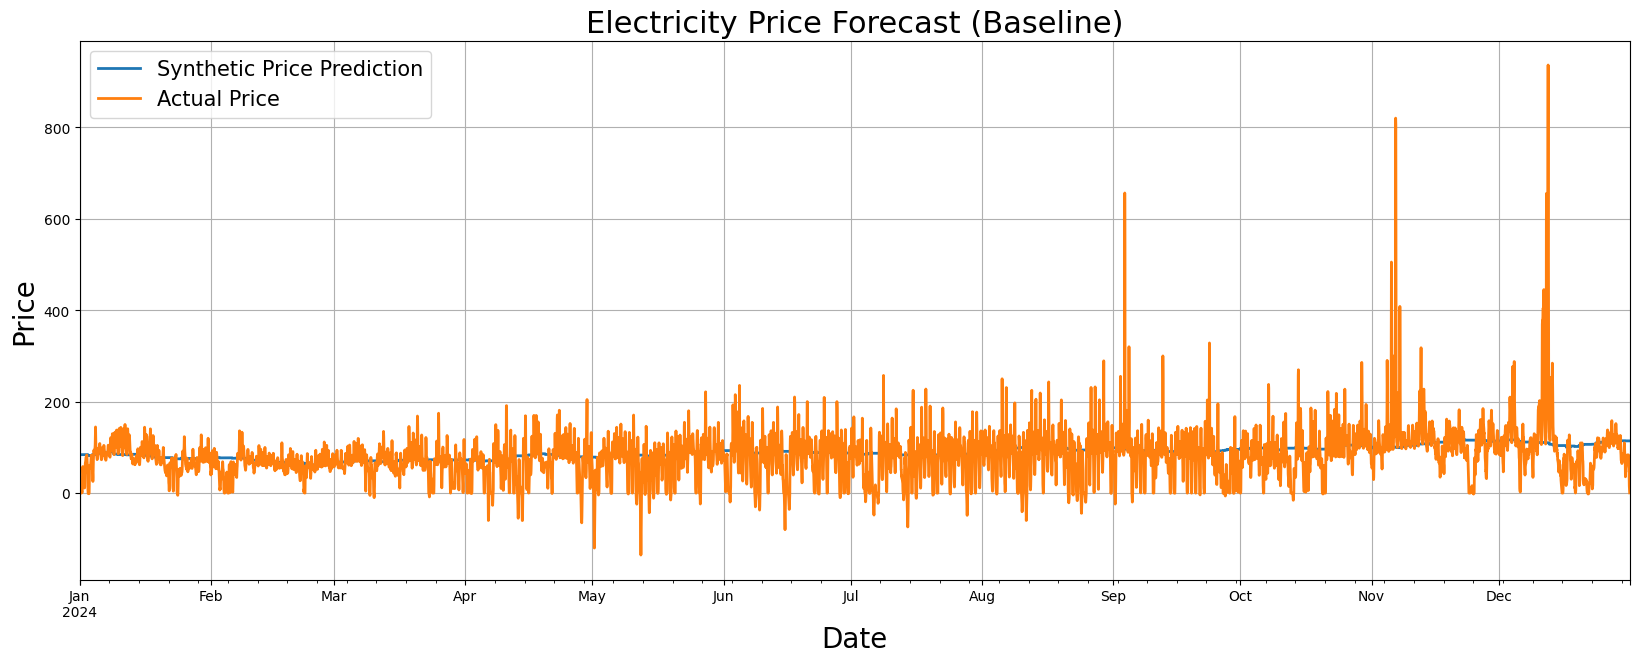

In [12]:
import matplotlib.pyplot as plt

model_name = 'Synthetic Price'

# Convert to datetime if needed
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

fig, ax = plt.subplots(figsize=(20, 7))

# Plot baseline predictions
forecast_df.set_index('ds')['y_pred'].plot(ax=ax, linewidth=2, label=f'{model_name} Prediction')

# Plot actual test values
test_df.set_index('ds')['y'].plot(ax=ax, linewidth=2, label='Actual Price')

# Formatting
ax.set_title('Electricity Price Forecast (Baseline)', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()

/scratch/slurm_tmpdir/job_25212577/ipykernel_511139/1201005719.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  unique_months = forecast_df['ds'].dt.to_period('M').unique()
/scratch/slurm_tmpdir/job_25212577/ipykernel_511139/1201005719.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  forecast_month = forecast_df[forecast_df['ds'].dt.to_period('M') == month]
/scratch/slurm_tmpdir/job_25212577/ipykernel_511139/1201005719.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  test_month = test_df[test_df['ds'].dt.to_period('M') == month]


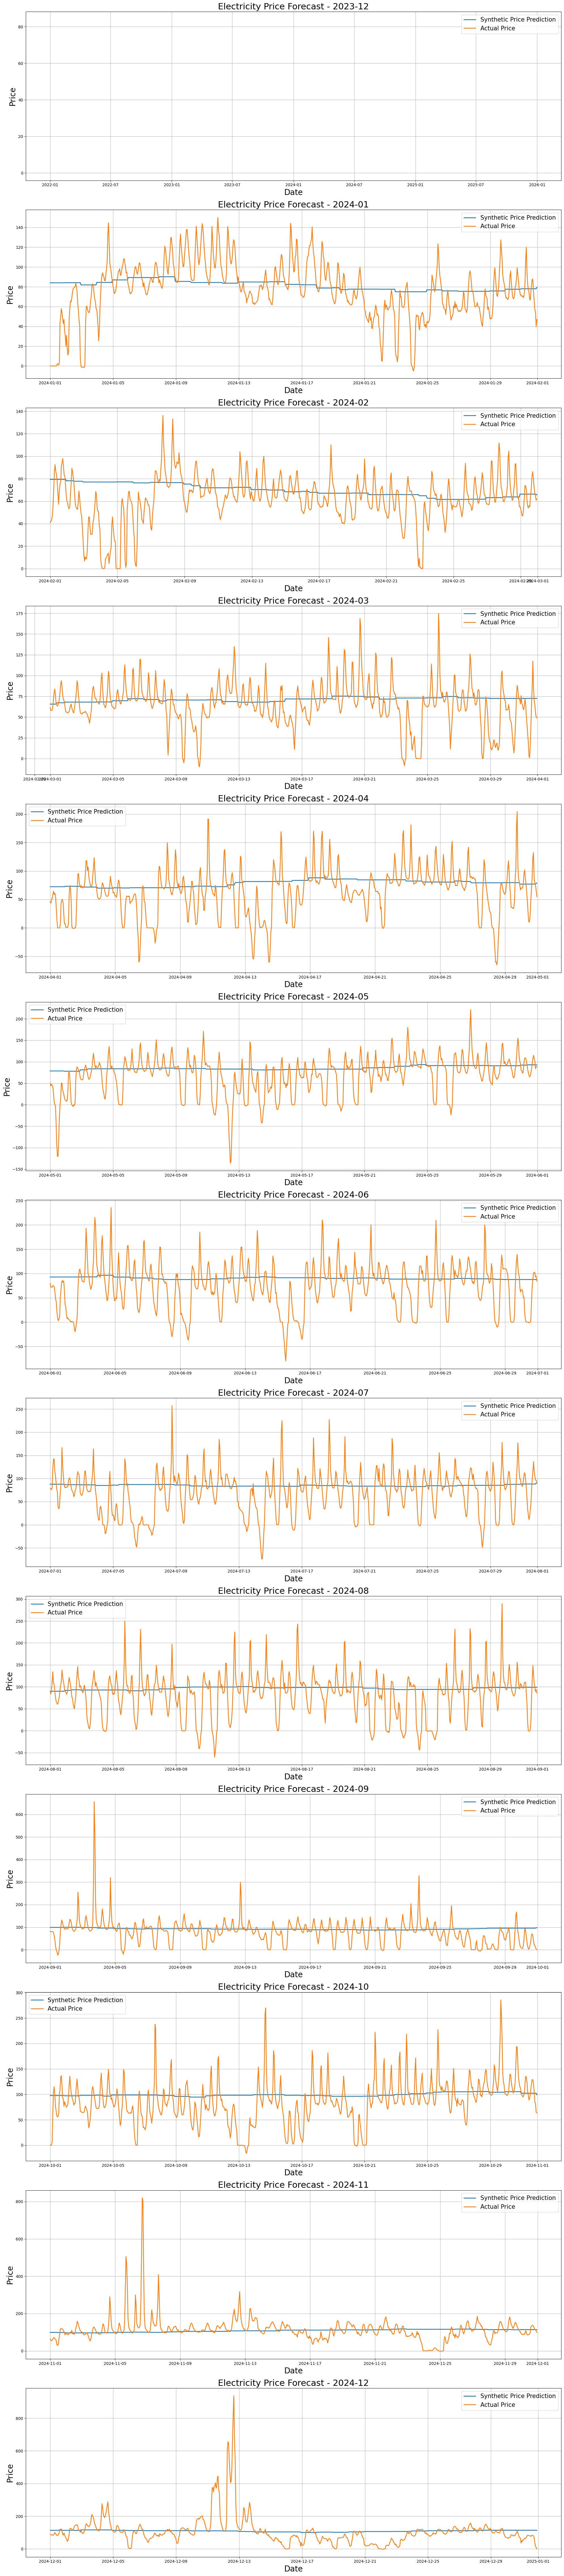

In [13]:
# Create a new figure with multiple subplots, one for each month
unique_months = forecast_df['ds'].dt.to_period('M').unique()
fig, axes = plt.subplots(len(unique_months), 1, figsize=(20, 7 * len(unique_months)))

# Handle the case where there's only 1 month
if len(unique_months) == 1:
    axes = [axes]

for i, month in enumerate(unique_months):
    month_str = str(month)
    forecast_month = forecast_df[forecast_df['ds'].dt.to_period('M') == month]
    test_month = test_df[test_df['ds'].dt.to_period('M') == month]
    
    axes[i].plot(forecast_month['ds'], forecast_month['y_pred'], linewidth=2, label=f'{model_name} Prediction')
    axes[i].plot(test_month['ds'], test_month['y'], linewidth=2, label='Actual Price')
    
    axes[i].set_title(f'Electricity Price Forecast - {month_str}', fontsize=22)
    axes[i].set_ylabel('Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=20)
    axes[i].legend(prop={'size': 15})
    axes[i].grid()

plt.tight_layout()
plt.show()

In [14]:
# Convert 'ds' to datetime if not already
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Group by 2-week periods
forecast_df['biweek'] = forecast_df['ds'].dt.to_period('2W')
test_df['biweek'] = test_df['ds'].dt.to_period('2W')

unique_biweeks = forecast_df['biweek'].unique()

fig, axes = plt.subplots(len(unique_biweeks), 1, figsize=(20, 7 * len(unique_biweeks)))
if len(unique_biweeks) == 1:
    axes = [axes]

for i, biweek in enumerate(unique_biweeks):
    biweek_str = str(biweek)
    forecast_biweek = forecast_df[forecast_df['biweek'] == biweek]
    test_biweek = test_df[test_df['biweek'] == biweek]
    
    axes[i].plot(forecast_biweek['ds'], forecast_biweek['y_pred'], linewidth=2, label=f'{model_name} Prediction')
    axes[i].plot(test_biweek['ds'], test_biweek['y'], linewidth=2, label='Actual Price')
    
    axes[i].set_title(f'Electricity Price Forecast - {biweek_str}', fontsize=22)
    axes[i].set_ylabel('Price', fontsize=20)
    axes[i].set_xlabel('Date', fontsize=20)
    axes[i].legend(prop={'size': 15})
    axes[i].grid()

plt.tight_layout()
plt.show()

/scratch/slurm_tmpdir/job_25212577/ipykernel_511139/3133980806.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  forecast_df['biweek'] = forecast_df['ds'].dt.to_period('2W')
/scratch/slurm_tmpdir/job_25212577/ipykernel_511139/3133980806.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  test_df['biweek'] = test_df['ds'].dt.to_period('2W')
